Import librairies and packages

In [2]:
from tdmclient import ClientAsync, aw

import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import Vision.CamCalib as calib
import Vision.EnvTracker as tracker
import time
import cv2
import threading

sys.path.insert(0, os.path.join(os.getcwd(), 'LocalNav/sensors'))
from local_occupancy import thymio_coords

sys.path.insert(0, os.path.join(os.getcwd(), 'plot'))
from plot import plot

sys.path.insert(0, os.path.join(os.getcwd(), 'LocalNav'))
sys.path.insert(0, os.path.join(os.getcwd(), 'GlobalNav'))
from LocalNav import localNav
#from GlobalNav import GlobalNav
#%matplotlib qt

Initialize components & objects

In [3]:
#Start Thymio
USE_THYMIO = True

if USE_THYMIO:
    #Create a Client Object:
    client = ClientAsync()
    node = await client.wait_for_node()
    await node.lock()

    client.process_waiting_messages()

In [4]:
def plotting_func(abs_pos, thymio_coords, goal_position, map_global, pointing_arrow):
    plot(abs_pos, thymio_coords, goal_position, map_global, pointing_arrow)
    plt.show()

In [5]:
# Parameters
MAP_W, MAP_H = (120, 120)  # In cm

# Position
abs_pos = [[20, 20, 0]] # absolute x,y,theta coordinates of the robot
# Goal Position
goal_position = [[80, 80]]

# Initialize camCalib object to retrieve camera parameters
cam_calib = calib.CamCalib(None, (16,9))
cam_mat, dist_coefs, rvecs, tvecs = cam_calib.load_camera_params()
quit = False
run = True
wait_for_map = True
map_created = False

# Initialize the environment tracker object to create global map and track thymio
env_tracker = tracker.EnvTracker((MAP_W, MAP_H), cam_mat, dist_coefs)

map_global = np.zeros((MAP_W, MAP_H))


Main loop (run thymio)

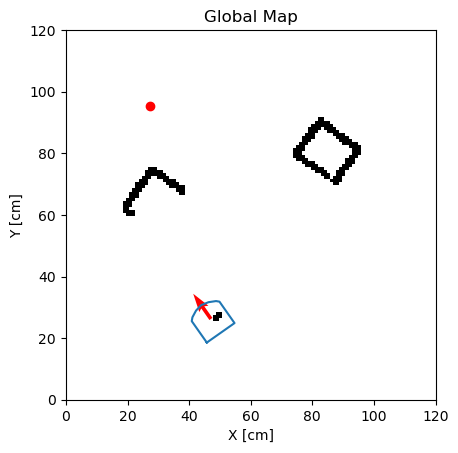

In [6]:
# Open camera feed & initialize map
cv2.destroyAllWindows()
cv2.namedWindow("Thymio Tracking", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Thymio Tracking", 1680, 1050)
cam_feed = cv2.VideoCapture(0)
cam_feed.set(cv2.CAP_PROP_FRAME_WIDTH, 1680)
cam_feed.set(cv2.CAP_PROP_FRAME_HEIGHT, 1050)
if not cam_feed.isOpened():
    print("ERROR :: Could not open camera video feed!")
map_created, map_global, goal_pose, thymio_init_pose = env_tracker.wait_for_map(cam_feed, cam_calib, window_name="Thymio Tracking")
goal_position = np.array([goal_pose[:]])
print("Thymio init pose: ", thymio_init_pose)

# Switch map X,Y
map_global = np.transpose(map_global)

# GLOBAL PLANNING 
if np.sum(goal_pose) >= 0 and np.sum(thymio_init_pose) > 0:
    # If valid pose for goal and thymio
    pass

# Adjustments before tracking
track_thymio = False
show_markers = False
frame_counter = 0
text_pose = 'POS: ??'
text_angle = 'ANGLE: ??'
text_vel = 'VEL: ??'
text_ang_vel = 'ANG. VEL: ??'
text_goal = f'GOAL: {np.round(goal_pose, 1)}'
pose_hist = np.zeros((2,10))
angle_hist = np.zeros(10)
cv2.resizeWindow("Thymio Tracking", 1200, 1000)

# Map is ready, run the thymio
plt.show(block = False)
quit = True
frame_count = 0
while run and not quit:
    # Acquire cam image and perform thymio tracking
    success, frame = cam_feed.read()
    if not success:
        run = False
    # Detect map & thymio
    frame_corrected, roi = cam_calib.undistord(frame, cam_mat, dist_coefs)
    x,y,w,h = roi
    frame_corrected = frame_corrected[y:y+h, x:x+w, :]
    if track_thymio:
        success, thymio_pose, thymio_vel, img_thymio = env_tracker.updateThymio(frame_corrected, show_markers)
        if frame_count % 100:
            env_tracker.updateMapROI(frame_corrected)
        img_sidebar = np.zeros((img_thymio.shape[0], 200, 3), dtype=np.uint8)
        if success:
            abs_pos = np.array([thymio_pose[:]])
            text_pose = f'POSE: {np.round(thymio_pose[:2], 1)}'
            text_angle = f'ANGLE: {round(thymio_pose[2]*180/math.pi, 0)}'
            text_vel = f'VEL: {np.round(thymio_vel[:2], 1)}'
            text_ang_vel = f'ANG. VEL: {round(thymio_vel[2]*180/math.pi, 1)}'
        cv2.putText(img_sidebar, text_pose, (10, 100), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_angle, (10, 175), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_vel, (10, 250), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_ang_vel, (10, 325), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_goal, (10, 400), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        # Concatenate images
        img_thymio = cv2.hconcat([img_thymio, img_sidebar])
    else:
        img_thymio = env_tracker.getProjectedMap(frame_corrected)
    cv2.imshow("Thymio Tracking",img_thymio)
    key = cv2.waitKey(1)
    if key == ord('q'):
        run = False
    elif key == ord(' '):
        # Track thymio or not
        track_thymio = not track_thymio
    elif key == ord('m'):
        show_markers = True
    
    if USE_THYMIO:
        await node.wait_for_variables({"prox.horizontal"})
        prox_horizontal = list(node.v.prox.horizontal)
        print(f'prox_hor: {prox_horizontal}')
    else:
        prox_horizontal = np.zeros(7)

    map_global = localNav(abs_pos, goal_position, prox_horizontal, map_global)

    # Plot
    #myThread = threading.Thread(target=plotting_func, args=(abs_pos, thymio_coords, goal_position, map_global, abs_pos[0][2]))
    #myThread.start()
    if frame_count % 30:
        clear_output(wait=True)  # Clear the previous plot
        plot(abs_pos, thymio_coords, goal_position, map_global, abs_pos[0][2])
        plt.show()
        #time.sleep(1)
    frame_count += 1

if cam_feed:
    cam_feed.release()
cv2.destroyAllWindows()